This script mostly works, but not always. Sometimes the images are weird and half-white. I could maybe do some more work but this is a good start.

In [1]:
import math
import requests
from PIL import Image
from requests.auth import HTTPBasicAuth
import os
import json
from io import BytesIO
from shapely.geometry import Polygon

In [2]:
# INPUTS

lat = -16.983333
lon = 35.208332
zoom = 14 # api supports up to 18 but the images aren't clear past 14

min_year = 2018
min_month = 1 # January

max_year = 2018
max_month = 12 # December

api_key = None
with open('api_key.txt') as f:
    api_key = f.readlines()[0].strip()
    
item_type = 'PSScene3Band'

In [3]:
def tilexy_to_deg(xtile, ytile, zoom, x, y):
    """Converts a specific location on a tile (x,y) to geocoordinates."""
    decimal_x = xtile + x / 256
    decimal_y = ytile + y / 256
    n = 2.0 ** zoom
    lon_deg = decimal_x / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * decimal_y / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

def deg_to_tilexy(lat_deg, lon_deg, zoom):
    """Converts geocoordinates to an x,y position on a tile."""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    x = ((lon_deg + 180.0) / 360.0 * n)
    y = ((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad)))
        / math.pi) / 2.0 * n)
    return (int((x % 1) * 256), int((y % 1) * 256))

def tile_to_deg(xtile, ytile, zoom):
    """Returns the coordinates of the northwest corner of a Slippy Map
    x,y tile"""
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

def deg_to_tile(lat_deg, lon_deg, zoom):
    """Converts coordinates into the nearest x,y Slippy Map tile"""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad)))
                 / math.pi) / 2.0 * n)
    return (xtile, ytile)

In [4]:
if min_month < 10:
    min_month = '0' + str(min_month)

if max_month < 10:
    max_month = '0' + str(max_month)

In [5]:
def create_cords(lat, lon, zoom):
    xtile, ytile = deg_to_tile(lat, lon, zoom)
    
    coords = [tilexy_to_deg(xtile, ytile, zoom, a, b) for a,b in [(0,0), (0,255), (255,255), (255,0)]]
    return [[b,a] for a,b in coords]

In [6]:
geo_json_geometry = {
  "type": "Polygon",
  "coordinates": [
      create_cords(lat, lon, zoom)
  ],
    
}

# filter for items the overlap with our chosen geometry
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geo_json_geometry,
}

# filter images acquired in a certain date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "{}-{}-01T00:00:00.000Z".format(min_year, min_month),
    "lte": "{}-{}-01T00:00:00.000Z".format(max_year, max_month)
  }
}

# filter any images which are more than 50% clouds
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 0.05
  }
}

# create a filter that combines our geo and date filters
# could also use an "OrFilter"
reservoir = {
  "type": "AndFilter",
  "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [7]:
# Search API request object
search_endpoint_request = {
  "item_types": [item_type],
  "filter": reservoir
}

result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(api_key, ''),
    json=search_endpoint_request)

In [8]:
# https://www.geo.university/pages/satellite-image-metadata-and-their-applications-in-remote-sensing
# useful explanation of some terms if you choose to look at them
res = json.loads(result.text)

In [9]:
if len(res['features']) == 0:
        print('No image found')

In [11]:
x, y = deg_to_tile(lat, lon, zoom)

In [12]:
polya = Polygon(create_cords(lat, lon, zoom)) 
coords = [tilexy_to_deg(x,y,zoom,a,b) for a,b in [(0,0), (1,0), (1,1), (0,1)]]
polyc = Polygon([(b,a) for (a,b) in coords])

good_idxs = []

for idx in range(len(res['features'])):
    polyb = Polygon(res['features'][idx]['geometry']['coordinates'][0])
    coords = [tilexy_to_deg(x,y,zoom,a,b) for a,b in [(0,0), (255,0), (255,255), (0,255)]]
    polyc = Polygon([(b,a) for (a,b) in coords])
    
    if polyb.contains(polya) and polyb.contains(polyc):
        good_idxs.append(idx)

In [199]:
item_id = res['features'][59]['id']

In [201]:
(item_type, item_id, zoom, x, y)

('PSScene3Band', '20160617_184554_0c79', 14, 4181, 6094)

In [202]:
url = 'https://tiles0.planet.com/data/v1/{}/{}/{}/{}/{}.png?api_key={}'.format(item_type, item_id, zoom, x, y, api_key)



In [203]:
response = requests.get(url)
if response.status_code >= 400:
    print('download error')

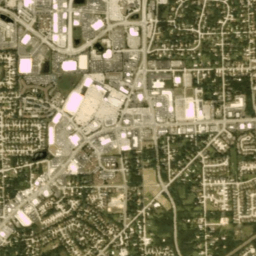

In [204]:
image = Image.open(BytesIO(response.content))
image

In [14]:
# can download all good images with this
images = []
for idx in good_idxs:
    item_id = res['features'][idx]['id']
    url = 'https://tiles0.planet.com/data/v1/{}/{}/{}/{}/{}.png?api_key={}'.format(item_type, item_id, zoom, x, y, api_key)
    response = requests.get(url)
    if response.status_code >= 400:
        print('download error')
    else:
        image = Image.open(BytesIO(response.content))
        images.append(image)
        